In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

In [ ]:
!pip install recordlinkage

In [ ]:
!pip install joblib==1.2.0

In [ ]:
!pip install scikit-learn==1.2.2

In [ ]:
!pip install numpy==1.24.2

# What is Record Linkage?

* ### Record Linkage is the task of finding and matching records that represent the same entity such as a person, even if those records are not identical and may contain errors, variations, or missing information.

* ### At CRDT we do not get a common key such as Social Security Number of Email that could link people across datasets.

* ### We rely mostly on the **persons name and birth date** to find matches.

*
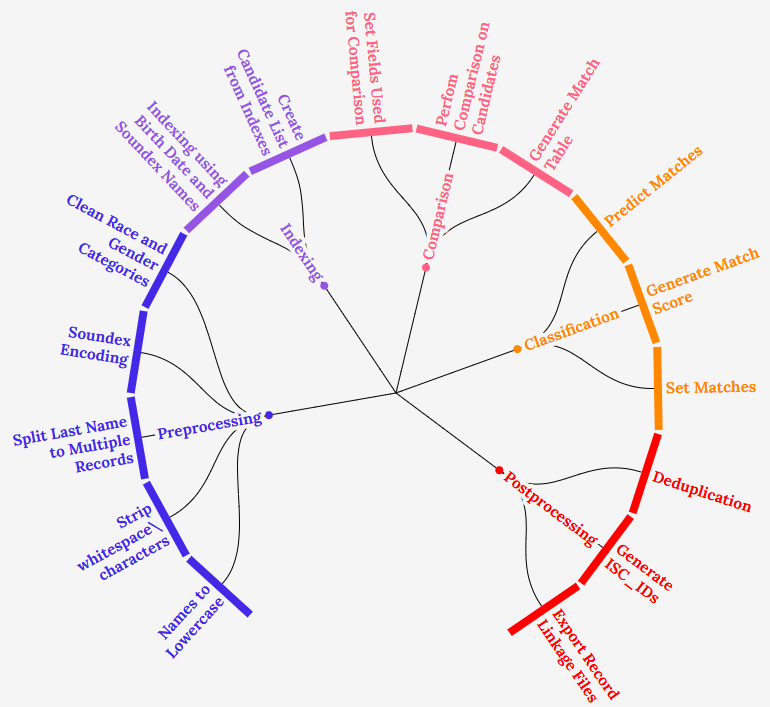
  

In [ ]:
from datetime import datetime
from joblib import load
import json
import numpy as np
import os
import pandas as pd
import plotly.express as px
import polars as pl
pl.Config.set_tbl_rows(30)
import polars.selectors as cs
import pprint
import os

import sys
WKSP = "/content/drive/My Drive/record_linkage"
sys.path.append(WKSP)
from record_linkage import RecordLinkage
RF_WKSP = "/content/drive/My Drive/random_forest"
sys.path.append(RF_WKSP)
from random_forest import RandomForest
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [ ]:
# flag if there is a label with this dataset that can be used for training an
# assessing accuracy
HAS_LABEL = True
# name of the label field
LABEL_FLD = 'true_match'
# models folder
MODELS_FOLDER = 'ml/models'
# dedup flag
DEDUP = False

# Demo Linking People Across Datasets

### **THE DATA USED IN THIS DEMO CONTAINS FAKE NAMES AND ATTRIBUTES**

* ### For the purpose of the demo lets say we have the a dataset for **CMS**  that contains **50,000 records containing names demographic information and birth dates**.
* ### We want to find people that match in another dataset called **Economic Services**
  * #### **For the purposes of the demo the Economic Services dataset is subset of the CMS dataset but there are different changes made to the Economic Services data.**

    * #### Extra samples of additional fake names not related to the CMS dataset are added to assess how well records are not matched with these samples.
    * #### Twins are also added, which contain similar records to the CMS dataset but a different id, the first name is slightly changed and the birth date and last name are the same.

    * #### Some of the changes:
      * Extra sample not dervived from main dataset
      * Create Twin - Change First Letter of Name
      * Matching Twin - Change First Letter of Name
      * Create Twin - Change Last Letter of Name
      * Matching Twin - Change Last Letter of Name
      * Added Hyphenated Name
      * Add Additional Last Name Without Hyphen                      
      * Removed Characters from Last Name
      * Removed Character from First Name
      * Removed Character from First and Last Name      
  
* ### The goal is be able to match people across datasets even though there are cases where data doesn't match up exactly



# [Preprocessing](https://recordlinkage.readthedocs.io/en/latest/ref-preprocessing.html)

### Preprocessing involves cleaning the data to have a better chance of being able to find matches of the same person in different datasets.
* ### **Race and Gender Category Mapping**
  * Example: CMS Has Gender Value of **Femaie** and Economic Services has Gender Value of **Woman**
  *  When the gender fields are compared **they will not be considered a match** because they have two different values even though they mean the same thing.
  *  A mapping file is used to **set categories to a common naming convention**.
  
    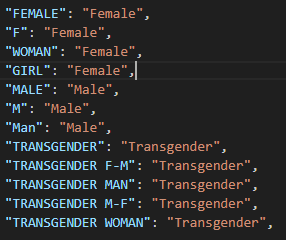

* ### **Split Different Parts of Hyphenated Names in Seperate Records**
  * If one data source has a hyphenated name another data source may only have one part of the name in their records.
  * This step works by keeping the hyphenated value but also creating new records for each part of the hyphenated name.
* ### **Cleaning Name Fields**
  * Convert all values to lower case so we are matching on a common case
  * Strip out special characters and white space
* ### **Phonetic Encoding**
  * Use a phonetic encoding algorithm called **Soundex** that create a four character code that indexes names based on how they are pronounced.
  * The idea is that if there are names with minor spelling differences, they will generate the same Soundex code.
  * Example Soundex Codes:
    * **Nicholas = N242**
    * **Nicolas  = N242**

In [ ]:
ds1_file_path = 'data/main_fake_dataset_50K_with_twins_rev1.csv'
ds2_file_path = 'data/sample_fake_dataset_50K_with_twins_rev1.csv'

In [ ]:
name_fields = ['first_name','middle_name','last_name']

In [ ]:
rl = RecordLinkage(dedup=DEDUP)

In [ ]:
ds1 = pl.read_csv(f"{WKSP}/{ds1_file_path}",schema_overrides={'birth_date':pl.Date})
ds1_dataset_key = 'index'

ds1 = ds1.with_columns(pl.col('name_last').str.replace('-',' ').str.strip_chars().str.split(by=' ').alias('name_last_list'))
ds1 = RecordLinkage.expand_multiple_values_to_new_rec(ds1,'name_last','name_last_list')


ds1 = RecordLinkage.assign_unique_key(df=ds1,
                                key_fld=ds1_dataset_key,
                                unique_key_name=rl.unique_key_name)
ds1 = RecordLinkage.rename_columns(ds1,
                             first_name='name_first',
                             middle_name='name_middle',
                             last_name='name_last',
                             birth_date='birth_date',
                             gender='gender',
                             race='bifsg_race',
                             latitude='latitude',
                             longitude='longitude')

ds1 = ds1.to_pandas()
ds1['birth_date'] = ds1['birth_date'].astype('datetime64[ns]')

ds1_ds = RecordLinkage.create_dataset_dict('ds1', ds1, ds1_dataset_key, rl.unique_key_name)

In [ ]:
ds2 = pl.read_csv(f"{WKSP}/{ds2_file_path}",schema_overrides={'birth_date':pl.Date})
ds2_dataset_key = 'index'

ds2 = ds2.with_columns(pl.col('name_last').str.replace('-',' ').str.strip_chars().str.split(by=' ').alias('name_last_list'))
ds2 = RecordLinkage.expand_multiple_values_to_new_rec(ds2,'name_last','name_last_list')

ds2 = RecordLinkage.assign_unique_key(df=ds2,
                                key_fld=ds2_dataset_key,
                                unique_key_name=rl.unique_key_name)
ds2 = RecordLinkage.rename_columns(ds2,
                             first_name='name_first',
                             middle_name='name_middle',
                             last_name='name_last',
                             birth_date='birth_date',
                             gender='gender',
                             race='bifsg_race',
                             latitude='latitude',
                             longitude='longitude')
ds2 = ds2.to_pandas()
ds2['birth_date'] = ds2['birth_date'].astype('datetime64[ns]')
ds2_ds = RecordLinkage.create_dataset_dict('ds2', ds2, ds2_dataset_key, rl.unique_key_name)

## Example of Modification Made to a Record





### Hyphenated Names
* #### The CMS dataset only has the first part of the last name, but the Economic Services had both parts of the hyphenated name and the individual part were created as seperate records.

In [ ]:
hyphen_index = '0decabd8-697f-4110-a3c5-6cab7ef15f0b'

In [ ]:
ds1.query(f"ds1_index == '{hyphen_index}'")[['ds1_index',
                                     'ds1_first_name_clean','ds1_first_name_soundex',
                                     'ds1_last_name_clean',	'ds1_last_name_soundex']]

,ds1_index,ds1_first_name_clean,ds1_first_name_soundex,ds1_last_name_clean,ds1_last_name_soundex
ds1_unique_pk,,,,,
0decabd8-697f-4110-a3c5-6cab7ef15f0b_1,0decabd8-697f-4110-a3c5-6cab7ef15f0b,melanie,M450,schmidt,S530


In [ ]:
ds2.query(f"ds2_index == '{hyphen_index}'")[['ds2_index','ds2_sample_modified_code',
                                     'ds2_first_name_clean','ds2_first_name_soundex',
                                     'ds2_last_name_clean',	'ds2_last_name_soundex']]

,ds2_index,ds2_sample_modified_code,ds2_first_name_clean,ds2_first_name_soundex,ds2_last_name_clean,ds2_last_name_soundex
ds2_unique_pk,,,,,,
0decabd8-697f-4110-a3c5-6cab7ef15f0b_1,0decabd8-697f-4110-a3c5-6cab7ef15f0b,Add Additional Last Name Without Hyphen,melanie,M450,schmidt,S530
0decabd8-697f-4110-a3c5-6cab7ef15f0b_2,0decabd8-697f-4110-a3c5-6cab7ef15f0b,Add Additional Last Name Without Hyphen,melanie,M450,schmidt george,S532
0decabd8-697f-4110-a3c5-6cab7ef15f0b_3,0decabd8-697f-4110-a3c5-6cab7ef15f0b,Add Additional Last Name Without Hyphen,melanie,M450,george,G620


### Remove Characters from Last Name
* #### The last name in Economic Services has a typo where the **ne** is missing from the last name Haynes.

In [ ]:
remchar_index = 'd402abf1-f4e8-418e-bfe8-38cf0220086d'

In [ ]:
ds1.query(f"ds1_index == '{remchar_index}'")[['ds1_index',
                                     'ds1_first_name_clean','ds1_first_name_soundex',
                                     'ds1_last_name_clean',	'ds1_last_name_soundex']]

,ds1_index,ds1_first_name_clean,ds1_first_name_soundex,ds1_last_name_clean,ds1_last_name_soundex
ds1_unique_pk,,,,,
d402abf1-f4e8-418e-bfe8-38cf0220086d_1,d402abf1-f4e8-418e-bfe8-38cf0220086d,krista,K623,haynes,H520


In [ ]:
ds2.query(f"ds2_index == '{remchar_index}'")[['ds2_index',
                                     'ds2_first_name_clean','ds2_first_name_soundex',
                                     'ds2_last_name_clean',	'ds2_last_name_soundex']]

,ds2_index,ds2_first_name_clean,ds2_first_name_soundex,ds2_last_name_clean,ds2_last_name_soundex
ds2_unique_pk,,,,,
d402abf1-f4e8-418e-bfe8-38cf0220086d_1,d402abf1-f4e8-418e-bfe8-38cf0220086d,krista,K623,hays,H200


### Twins
* #### In the CMS dataset there is only one person but in Economic Services there are two people where the only difference is the last letter of the first name.

In [ ]:
# ds2.query("ds2_sample_modified_code.str.contains('Matching Twin -  Change Last Letter')").sample()

In [ ]:
twin_index = "e9e07288-fa1d-4701-9665-723933266a49"

In [ ]:
ds1.query(f"ds1_index.str.contains('{twin_index}')")[['ds1_index',
                                     'ds1_first_name_clean','ds1_first_name_soundex',
                                     'ds1_last_name_clean',	'ds1_last_name_soundex','ds1_birth_date']]

,ds1_index,ds1_first_name_clean,ds1_first_name_soundex,ds1_last_name_clean,ds1_last_name_soundex,ds1_birth_date
ds1_unique_pk,,,,,,
e9e07288-fa1d-4701-9665-723933266a49_1,e9e07288-fa1d-4701-9665-723933266a49,christine,C623,miller,M460,1993-11-17


In [ ]:
ds2.query(f"ds2_index.str.contains('{twin_index}')")[['ds2_index',
                                     'ds2_first_name_clean','ds2_first_name_soundex',
                                     'ds2_last_name_clean',	'ds2_last_name_soundex','ds2_birth_date']]

,ds2_index,ds2_first_name_clean,ds2_first_name_soundex,ds2_last_name_clean,ds2_last_name_soundex,ds2_birth_date
ds2_unique_pk,,,,,,
e9e07288-fa1d-4701-9665-723933266a49_1,e9e07288-fa1d-4701-9665-723933266a49,christine,C623,miller,M460,1993-11-17
e9e07288-fa1d-4701-9665-723933266a49|2_1,e9e07288-fa1d-4701-9665-723933266a49|2,christina,C623,miller,M460,1993-11-17


Get Record Linkage Combinatons

For DLRs we perform record linkage for multiple data sources this step just define the dataset combinations that the record linkage process will be performed on.  SInce there are only two datasets in this example there is only one record linkage combination.

In [ ]:
ds = {**ds1_ds, **ds2_ds}
rl_dict = RecordLinkage.get_rl_combinations(ds=ds,main_ds='ds1',dedup=DEDUP)
pprint.pprint(rl_dict)

ds1_ds2
{'ds1_ds2': {'name': 'ds1_ds2',
             'rl': <record_linkage.RecordLinkage object at 0x7b485f478090>,
             'rl_ds1': 'ds1',
             'rl_ds1_alternate_key': None,
             'rl_ds1_dataset_key': 'ds1_index',
             'rl_ds1_unique_key': 'ds1_unique_pk',
             'rl_ds2': 'ds2',
             'rl_ds2_alternate_key': None,
             'rl_ds2_dataset_key': 'ds2_index',
             'rl_ds2_unique_key': 'ds2_unique_pk'}}


# [Indexing](https://recordlinkage.readthedocs.io/en/latest/ref-index.html)

* ## When trying to match records we don’t want to compare every single record with every other record.

* ## We use indexing to narrow down the list to just the most likely matches.

* ## We create two separate indexes: one based on first names and birthdates, and another based on last names and birthdates.

* ## Since names can have different spellings we index on the Soundex version of the names which groups together similar-sounding names.

* ## Birthdates must match exactly, but the Soundex names don’t have to match perfectly.

* ## By having separate indexes for first and last names, we can still find potential matches even if one of the names is misspelled.

* ## These indexes help us build a shorter list of possible matches—called candidate pairs—which we then use in the comparison step.


In [ ]:
for rl_key in rl_dict.keys():
    RecordLinkage.run_sorted_neighborhood_indexing(rl_dict[rl_key],ds,window_size=9)
    print("Sample Candidate Pair:", rl_dict[rl_key]['rl'].candidates[0])

Record Linkage Indexing for ds1_ds2
Candidates using Sorted Neighborhood using Soundex First Name and Birthdate: 41126
Candidates using Sorted Neighborhood using Soundex Last Name and Birthdate: 34874
Combined Possible Candidates using Sorted Neighborhood: 45852

Sample Candidate Pair: ('00034234-7eb1-4d0d-8d42-bb85f28e84c9_1', '00034234-7eb1-4d0d-8d42-bb85f28e84c9_1')


# [Comparison](https://recordlinkage.readthedocs.io/en/latest/ref-compare.html)

* ## There are different comparison methods based on what fields are available in both datasets
* ## Each method will have the fields that will be used for the comparison, a matching method for each field such as exact matching or string similarity and a weight field.
  * ### Fields are weighted differently since some fields are more important to matching than others
* ## After the comparison a binary table is created with every field used in the comparison
  * ### **0 indicates that the field did not match**
  * ### **1 indicates they did match**

In [ ]:
with open(f'{WKSP}/compare_methods.json','r') as cm:
    compare_methods = json.load(cm)

In [ ]:
rl_dict['ds1_ds2']['compare_name'] = "name_race_gender_exact_name"

In [ ]:
for rl_key in rl_dict:
    # print(rl_key)
    compare_name = rl_dict[rl_key]['compare_name']
    compare_flds = compare_methods[compare_name]

    # print(f'\nRecord Linkage: {rl_key}')
    match_flds = [x['match_fldname'] for x in compare_flds]

    rl_dict[rl_key]['compare_fields'] = (
        RecordLinkage.set_comparison_fields(compare_flds,
        rl_dict[rl_key]['rl_ds1'],
        rl_dict[rl_key]['rl_ds2'])
        )

    rl_dict[rl_key]['rl'].compare_records(rl_dict[rl_key]['compare_fields'])

Match Fields: ['match_sdx_first', 'match_sdx_middle', 'match_sdx_last', 'match_first_exact', 'match_middle_exact', 'match_last_exact', 'match_first', 'match_middle', 'match_last', 'match_birth_date', 'match_race', 'match_gender']
("Weights: {'match_sdx_first': 0.05, 'match_sdx_middle': 0.02, "
 "'match_sdx_last': 0.05, 'match_first_exact': 0.1, 'match_middle_exact': 0.1, "
 "'match_last_exact': 0.2, 'match_first': 0.1, 'match_middle': 0.05, "
 "'match_last': 0.15, 'match_birth_date': 0.1, 'match_race': 0.04, "
 "'match_gender': 0.04}")
There are 45,852 matching candidates


In [ ]:
rl_dict[rl_key]['rl'].comps

match_sdx_first  \
ds1_unique_pk                          ds2_unique_pk                                               
00034234-7eb1-4d0d-8d42-bb85f28e84c9_1 00034234-7eb1-4d0d-8d42-bb85f28e84c9_1                  1   
00054368-f30d-4b33-aa3b-61377550e218_1 00054368-f30d-4b33-aa3b-61377550e218_1                  1   
                                       00054368-f30d-4b33-aa3b-61377550e218|2_1                0   
00095229-fb92-430d-b4c8-9910db84876d_1 00095229-fb92-430d-b4c8-9910db84876d_1                  1   
000a390c-f43d-45ab-8151-6c66367c1810_1 000a390c-f43d-45ab-8151-6c66367c1810_1                  1   
...                                                                                          ...   
fffba240-42f1-4b5b-b1da-52bc83e0ebe2_1 fffba240-42f1-4b5b-b1da-52bc83e0ebe2|2_1                0   
fffdbcdb-3dac-4a4b-b159-6450fbc83049_1 fffdbcdb-3dac-4a4b-b159-6450fbc83049_1                  1   
                                       fffdbcdb-3dac-4a4b-b159-6450fbc83049_2                  1   
                                       fffdbcdb-3dac-4a4b-b159-6450fbc83049_3                  1   
fffe2827-403a-4198-89b0-7a52e812a84b_1 fffe2827-403a-4198-89b0-7a52e812a84b_1                  1   

                                                                                 match_sdx_middle  \
ds1_unique_pk                          ds2_unique_pk                                                
00034234-7eb1-4d0d-8d42-bb85f28e84c9_1 00034234-7eb1-4d0d-8d42-bb85f28e84c9_1                   0   
00054368-f30d-4b33-aa3b-61377550e218_1 00054368-f30d-4b33-aa3b-61377550e218_1                   1   
                                       00054368-f30d-4b33-aa3b-61377550e218|2_1                 0   
00095229-fb92-430d-b4c8-9910db84876d_1 00095229-fb92-430d-b4c8-9910db84876d_1                   0   
000a390c-f43d-45ab-8151-6c66367c1810_1 000a390c-f43d-45ab-8151-6c66367c1810_1                   0   
...                                                                                           ...   
fffba240-42f1-4b5b-b1da-52bc83e0ebe2_1 fffba240-42f1-4b5b-b1da-52bc83e0ebe2|2_1                 0   
fffdbcdb-3dac-4a4b-b159-6450fbc83049_1 fffdbcdb-3dac-4a4b-b159-6450fbc83049_1                   1   
                                       fffdbcdb-3dac-4a4b-b159-6450fbc83049_2                   1   
                                       fffdbcdb-3dac-4a4b-b159-6450fbc83049_3                   1   
fffe2827-403a-4198-89b0-7a52e812a84b_1 fffe2827-403a-4198-89b0-7a52e812a84b_1                   1   

                                                                                 match_sdx_last  \
ds1_unique_pk                          ds2_unique_pk                                              
00034234-7eb1-4d0d-8d42-bb85f28e84c9_1 00034234-7eb1-4d0d-8d42-bb85f28e84c9_1                 1   
00054368-f30d-4b33-aa3b-61377550e218_1 00054368-f30d-4b33-aa3b-61377550e218_1                 1   
                                       00054368-f30d-4b33-aa3b-61377550e218|2_1               1   
00095229-fb92-430d-b4c8-9910db84876d_1 00095229-fb92-430d-b4c8-9910db84876d_1                 1   
000a390c-f43d-45ab-8151-6c66367c1810_1 000a390c-f43d-45ab-8151-6c66367c1810_1                 1   
...                                                                                         ...   
fffba240-42f1-4b5b-b1da-52bc83e0ebe2_1 fffba240-42f1-4b5b-b1da-52bc83e0ebe2|2_1               1   
fffdbcdb-3dac-4a4b-b159-6450fbc83049_1 fffdbcdb-3dac-4a4b-b159-6450fbc83049_1                 0   
                                       fffdbcdb-3dac-4a4b-b159-6450fbc83049_2                 1   
                                       fffdbcdb-3dac-4a4b-b159-6450fbc83049_3                 0   
fffe2827-403a-4198-89b0-7a52e812a84b_1 fffe2827-403a-4198-89b0-7a52e812a84b_1                 1   

                                                                                 match_first_exact  \
ds1_unique_pk                          ds2_unique_pk                        

# [Classification](https://recordlinkage.readthedocs.io/en/latest/ref-classifiers.html)

* ## A classification model uses the comps table shown above and **makes a prediction as to whether the person is a match (1) or not (0)** and stores the result in a field called **match_pred**
* ## The match score is calculated using the weights mentioned in the comparison section to **calculate a score between 0 and 1** and stores the result in a field called **match_score**


In [ ]:
rf_comps_name_race_gender_exact_name = load(f'{WKSP}/{MODELS_FOLDER}/rf_model_name_race_gender_exact_name_20250107.joblib')
rl_dict['ds1_ds2']['model'] = rf_comps_name_race_gender_exact_name

In [ ]:
for key in rl_dict:
    print(f'\nRecord Linkage: {key}')
    model = rl_dict[key]['model']
    rl_dict[key]['rl'].predict(model)
    rl_dict[key]['rl'].calc_match_score()
    comps = rl_dict[key]['rl'].comps
    if HAS_LABEL:
        ds_key1 = rl_dict[key]['rl'].ds1_dataset_key
        ds_key2 = rl_dict[key]['rl'].ds2_dataset_key
        rl_dict[key]['rl'].comps[LABEL_FLD] = np.where(rl_dict[key]['rl'].comps[ds_key1] == rl_dict[key]['rl'].comps[ds_key2],1,0)
        rl_dict[key]['rl'].comps['tp'] = np.where(((comps[LABEL_FLD] == 1) & (comps['match_pred'] == 1)),1,0)
        rl_dict[key]['rl'].comps['fn'] = np.where(((comps[LABEL_FLD] == 1) & (comps['match_pred'] == 0)),1,0)
        rl_dict[key]['rl'].comps['tn'] = np.where(((comps[LABEL_FLD] == 0) & (comps['match_pred'] == 0)),1,0)
        rl_dict[key]['rl'].comps['fp'] = np.where(((comps[LABEL_FLD] == 0) & (comps['match_pred'] == 1)),1,0)
        rl_dict[key]['rl'].comps = comps
    del comps


Record Linkage: ds1_ds2
There were 41,239 out of 45,852 candidates (90%) predicted as matches


### Match Results for Hyphenated Names Example
* #### The best match recorded was with the record containing only **part of the hyphenated name** and not the hyphenated name iteself.

In [ ]:
rl_dict[key]['rl'].comps.query(f"ds1_index == '{hyphen_index}'")[['ds1_unique_pk','ds2_unique_pk','match_pred','match_score','true_match']]

,ds1_unique_pk,ds2_unique_pk,match_pred,match_score,true_match
2539,0decabd8-697f-4110-a3c5-6cab7ef15f0b_1,0decabd8-697f-4110-a3c5-6cab7ef15f0b_1,1,1.00,1
2540,0decabd8-697f-4110-a3c5-6cab7ef15f0b_1,0decabd8-697f-4110-a3c5-6cab7ef15f0b_2,1,0.75,1
2541,0decabd8-697f-4110-a3c5-6cab7ef15f0b_1,0decabd8-697f-4110-a3c5-6cab7ef15f0b_3,1,0.60,1


### Match Results for Remove Characters from Last Name Example
* #### Because of the indexing even though the last name didn't match exactly they were still considered a candidate pair

In [ ]:
rl_dict[key]['rl'].comps.query(f"ds1_index == '{remchar_index}'")[['ds1_unique_pk','ds2_unique_pk','match_pred','match_score','true_match']]

,ds1_unique_pk,ds2_unique_pk,match_pred,match_score,true_match
38019,d402abf1-f4e8-418e-bfe8-38cf0220086d_1,d402abf1-f4e8-418e-bfe8-38cf0220086d_1,1,0.75,1


### Match Results for Twins Example
* #### Even though both are predicted as matches there is a deduplication step discussed in the **Postprocessing** section to handle these cases.

In [ ]:
rl_dict[key]['rl'].comps.query(f"ds1_index.str.contains('{twin_index}')")[['ds1_unique_pk','ds2_unique_pk','match_pred','match_score','true_match']]

,ds1_unique_pk,ds2_unique_pk,match_pred,match_score,true_match
41921,e9e07288-fa1d-4701-9665-723933266a49_1,e9e07288-fa1d-4701-9665-723933266a49_1,1,1.00,1
41922,e9e07288-fa1d-4701-9665-723933266a49_1,e9e07288-fa1d-4701-9665-723933266a49|2_1,1,0.73,0


## [Evaluation](https://recordlinkage.readthedocs.io/en/latest/ref-evaluation.html)

* ### Visualize how the match scores and predictions vary.
* ### Useful in determining the threshold to use when classifying candidates as matches
* ### The prediction and match score are both used to determine matches

In [ ]:
for key in rl_dict:
    print(f'\nRecord Linkage: {key}')
    rl_dict[key]['rl'].get_score_pred_summary()
    scores_pred = rl_dict[key]['rl'].scores_pred.explode(['predictions','number_rows'])
    fig = px.line(scores_pred,
                x="match_score",
                y="number_rows",
                color='predictions',
                color_discrete_sequence=['red','green'],
                title=f'Predictions by Score for {key}',
                labels={
                        "match_score": "Match Score",
                        "number_rows": "Number of Records",
                        "predictions": "Prediction"
                    },
                )
    fig.show()


Record Linkage: ds1_ds2


In [ ]:
# setup a list of thresholds for each record linkage
MATCH_SCORE_THRESHOLD = [.60]
for thresh,key in zip(MATCH_SCORE_THRESHOLD,rl_dict):
    print(f'\nRecord Linkage: {key}, Threshold: {thresh}')
    rl_dict[key]['rl'].set_matches(f"match_score >= {thresh} and match_pred == 1")
    rl_dict[key]['rl_output'] = rl_dict[key]['rl'].process_duplicates()
    rl_dict[key]['rl_output'] = rl_dict[key]['rl_output'].rename({'match_score':f'{key}_match_score'}).to_pandas()


Record Linkage: ds1_ds2, Threshold: 0.6
There are 40,854 matches

Checking Duplicates

Found 22665 duplicate records between ds1_unique_pk and ds2_unique_pk
Number of Total Records Before Deduplication: 40854
Number of Total Unique Keys in ds1_unique_pk Before Deduplication: 27101
Number of Duplicate Records: 22665
Number of Duplicated Unique Keys in ds1_unique_pk: 8912
Data grouped by ds1_unique_pk and sorted by highest match score.
Keeping Highest Scoring Records for each ds1_unique_pk key
Number of Records to Keep: 8913
Number of Unique Keys in ds1_unique_pk to Keep: 8912
Number of Records to Remove: 13752
Number of Unique Keys in ds1_unique_pk to Remove: 8911
Number of Removed Records in Dataset After Deduplication: 0
Number of Kept Records in Dataset After Deduplication: 8913
Number of Total Records After Deduplication: 27102
Number of Total Unique Keys in ds1_unique_pk After Deduplication: 27101

Found 2 duplicate records between ds2_unique_pk and ds1_unique_pk
Number of Total R

# Postprocessing

## Deduplication
* ### There may be cases where a key from one data source is matched with two or more keys from another data source that have **different match scores**. (Twins Example)
  * ### WIth cases like this the highest scoring match will be kept.

* ### There may be cases where a key from one data source is matched with two or more keys from another data source that have **the same match score**.
  * ### Cases such as this will be treated as the same person and be given the same ISC_ID

## Generating ISC_IDs
* ### **ISC_IDs** are randomly generated ids provided in a Data License Request (DLR) instead of providing PII or a data partner provided id.
* ### They represent a unique person and can be used to link people across datasets in the DLR output.
* ### ISC_IDs are not linkable between different DLR's

## Match Stats

* ### Number of Ids from Economic Services that are In CMS Dataset: 27,202
* ### Number of All Ids from Economic Services (Includes Extra Samples and Twins): 44,352
* ### Number of CMS Ids Matched with Economic Services Dataset: 27,101 out of 27,202 (99.6%)
* ### Number of Extra Sample\Twin Ids Matched In CMS Datasets: 2
* ### Number of CMS Ids Not Matched With Economic Services Dataset: 101 (0.4%)

In [ ]:
# if there was more than one record linkage combination they would all be combined
# into one data frame
rl_output_list = [rl_dict[key]['rl_output'] for key in rl_dict]
rl_output_all = None
for i,df in enumerate(rl_output_list):
    if i == 0:
        rl_output_all = df
    else:
        rl_output_all = rl_output_all.merge(df,how='outer')

In [ ]:
# get all records including non matches all in one data frame
all_recs_list = [rl_output_all] + [ds[d]['datasource'][[ds[d]['dataset_key']]].reset_index(drop=True) for d in ds.keys()]
all_recs = None
for i,df in enumerate(all_recs_list):
    if i == 0:
        all_recs = df
    else:
        all_recs = all_recs.merge(df,how='outer')
all_recs = pl.from_pandas(all_recs).with_row_index('index',1)
all_recs = all_recs.sort(by='index')

In [ ]:
# deduplication step
for key in rl_dict:
    print(f'\nRecord Linkage: {key}')
    ds1_key = rl_dict[key]['rl_ds1_dataset_key']
    ds2_key = rl_dict[key]['rl_ds2_dataset_key']
    match_score_fld = f"{key}_match_score"

    all_recs = RecordLinkage.assign_duplicates_same_index2(all_recs,ds1_key)
    all_recs = RecordLinkage.assign_duplicates_same_index2(all_recs,ds2_key)
    all_recs = (all_recs
                .filter(pl.any_horizontal(cs.exclude('index').is_not_null()))
                .sort(by='index'))


Record Linkage: ds1_ds2


Removing duplicates of ds1_index field complete
Rows before removing duplicates: 76,986
Number of unique index values before removing duplicates: 76,986
Duplicate rows: 14,610
Number of unique index values in duplicates: 14,610
Rows after removing duplicates: 76,987
Number of unique index values after removing duplicates: 67,251


Removing duplicates of ds2_index field complete
Rows before removing duplicates: 76,987
Number of unique index values before removing duplicates: 67,251
Duplicate rows: 14,610
Number of unique index values in duplicates: 4,875
Rows after removing duplicates: 76,988
Number of unique index values after removing duplicates: 67,251


In [ ]:
os.makedirs('rl',exist_ok=True)
all_recs_parquet_path = 'rl/all_recs.parquet'
all_recs.write_parquet(all_recs_parquet_path)
print(f'Data frame written to {all_recs_parquet_path}')

Data frame written to rl/all_recs.parquet


In [ ]:
isc_ids_df = RecordLinkage.generate_isc_ids(all_recs,'index')
print(f"Number of ISC_ID Records: {isc_ids_df.height:,}")

Range of Possible IDs
Start: 134502, End: 470757
Number of ISC_ID Records: 67,251


In [ ]:
print(f"All Recs Dataframe Rows: {all_recs.height:,}")
print(f"All Recs Dataframe Unique Keys: {all_recs['index'].n_unique():,}")

All Recs Dataframe Rows: 76,986
All Recs Dataframe Unique Keys: 67,251


In [ ]:
all_recs_isc_id = (all_recs
                   .join(isc_ids_df,on='index')
                   .drop('index')
                   .unique())
print(f"All Recs ISC_ID Dataframe Rows: {all_recs_isc_id.height:,}")
print(f"All Recs ISC_ID Dataframe Unique Keys: {all_recs_isc_id['isc_id'].n_unique():,}")

os.makedirs('rl',exist_ok=True)
all_recs_isc_id_parquet_path = 'rl/all_recs_isc_id.parquet'
all_recs_isc_id.write_parquet(all_recs_isc_id_parquet_path)
print(f'Data frame written to {all_recs_isc_id_parquet_path}')

All Recs ISC_ID Dataframe Rows: 67,251
All Recs ISC_ID Dataframe Unique Keys: 67,251
Data frame written to rl/all_recs_isc_id.parquet


In [ ]:
# people that matched with another dataset
match_score_fields = [f'{k}_match_score' for k in rl_dict]
matches_isc_id = (all_recs_isc_id
                  .filter(~pl.all_horizontal([all_recs_isc_id[col].is_null()
                                              for col in match_score_fields]))
                  .unique()
                  )

os.makedirs('rl',exist_ok=True)
matches_parquet_path = 'rl/matches_isc_id.parquet'
matches_isc_id.write_parquet(matches_parquet_path)
print(f'Data frame written to {matches_parquet_path}')

Data frame written to rl/matches_isc_id.parquet


In [ ]:
matches_isc_id.shape

(27101, 4)

In [ ]:
matches_isc_id.to_pandas().merge(ds2,on='ds2_index').query("ds2_sample_modified_code.str.contains('Twin')")

,ds1_index,ds2_index,ds1_ds2_match_score,isc_id,ds2_name,ds2_name_title,ds2_first_name,ds2_middle_name,ds2_name_suffix,ds2_soundex_first,...,ds2_address,ds2_full_addre,ds2_sample_modified_code,ds2_last_name,ds2_first_name_clean,ds2_first_name_soundex,ds2_middle_name_clean,ds2_middle_name_soundex,ds2_last_name_clean,ds2_last_name_soundex
9,c462b94b-d34c-4ca6-a83a-8cfc55d94bea,c462b94b-d34c-4ca6-a83a-8cfc55d94bea,1.0,388412,Nicole Madden,None,Nicole,Jessica,None,N240,...,17511 AUSTINS CREEK DR,17511 AUSTINS CREEK DR CHARLOTTE NC 28278,Matching Twin - Change First Letter of Name,Madden,nicole,N240,jessica,J220,madden,M350
24,8063b683-7665-4cf5-8dc4-77806743dddb,8063b683-7665-4cf5-8dc4-77806743dddb,1.0,138527,David Williamson,None,David,Francisco,None,D130,...,7030 NORTH MILLS RD,7030 NORTH MILLS RD CHARLOTTE NC 28216,Matching Twin - Change Last Letter of Name,Williamson,david,D130,francisco,F652,williamson,W452
29,72f4840a-617b-4de0-9a39-ff48acf753ee,72f4840a-617b-4de0-9a39-ff48acf753ee,1.0,350132,Willie Griffin,None,Willie,Timothy,None,W400,...,15005 SPRINGWOOD ESTATE DR,15005 SPRINGWOOD ESTATE DR CHARLOTTE NC 28273,Matching Twin - Change Last Letter of Name,Griffin,willie,W400,timothy,T530,griffin,G615
40,310d602f-e308-4a6b-9eac-9f2fdd12e730,310d602f-e308-4a6b-9eac-9f2fdd12e730,1.0,397821,Joseph Holmes,None,Joseph,Kevin,None,J210,...,8250 KNIGHTS BRIDGE RD,8250 KNIGHTS BRIDGE RD CHARLOTTE NC 28210,Matching Twin - Change Last Letter of Name,Holmes,joseph,J210,kevin,K150,holmes,H452
41,07cab2fc-422d-4e9d-bdff-eb82c2db8cd9,07cab2fc-422d-4e9d-bdff-eb82c2db8cd9,1.0,304454,Sarah Mcbride,None,Sarah,Teresa,None,S600,...,7704 WATERFORD GLEN LP 437,7704 WATERFORD GLEN LP 437 CHARLOTTE NC 28226,Matching Twin - Change Last Letter of Name,Mcbride,sarah,S600,teresa,T620,mcbride,M216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36784,1c96f861-7f8a-45b5-b8cc-8a92ebf205ee,1c96f861-7f8a-45b5-b8cc-8a92ebf205ee,1.0,362880,Eric Schultz,None,Eric,John,None,E620,...,6328 BRIDLEWOOD LN,6328 BRIDLEWOOD LN CHARLOTTE NC 28215,Matching Twin - Change First Letter of Name,Schultz,eric,E620,john,J500,schultz,S432
36786,06ca7c85-91ce-404e-9c1d-4b41a2d04caf,06ca7c85-91ce-404e-9c1d-4b41a2d04caf,1.0,299880,Donna Reed,None,Donna,Angela,None,D500,...,5835 PALMER DR,5835 PALMER DR CHARLOTTE NC 28212,Matching Twin - Change First Letter of Name,Reed,donna,D500,angela,A524,reed,R300
36792,3d0d2a45-ce8b-49ee-a4bf-6fd0c762bf86,3d0d2a45-ce8b-49ee-a4bf-6fd0c762bf86,1.0,193833,Timothy Wise,None,Timothy,John,None,T530,...,5921 HORSE PASTURE LN 234,5921 HORSE PASTURE LN 234 CHARLOTTE NC 28269,Matching Twin - Change First Letter of Name,Wise,timothy,T530,john,J500,wise,W200
36821,5f6e6a7c-ee57-4846-964b-814cab848164,5f6e6a7c-ee57-4846-964b-814cab848164,1.0,400434,Ronnie Williams,None,Ronnie,Brendan,None,R500,...,909 BYDAND CT,909 BYDAND CT CHARLOTTE NC 28215,Matching Twin - Change First Letter of Name,Williams,ronnie,R500,brendan,B653,williams,W452


Match Stats

This section is specific to the sample dataset created to test record linkage process.  There is a sample modified code field that was created in the sample dataset that shows how the record was modfied in order to test record linkage.  One modification to the sample dataset was adding extra records that are not part of the main dataset and should not be matched.  The output will show the number of ids in the sample not including extra records, the number of ids including extra records and the number of ids matched and not matched.  For the ids not matched what sample modified code were linked to non matches.

In [ ]:
non_extra_samples = pl.from_pandas(ds2.query("ds2_sample_modified_code not in  ['Extra sample not dervived from main dataset','Created Twin - Change First Letter of Name','Created Twin - Change Last Letter of Name']"))
non_extra_samples_id_counts = non_extra_samples['ds2_index'].n_unique()
all_sample_id_counts = ds2['ds2_index'].nunique()
non_extra_samples['ds2_sample_modified_code'].value_counts()

ds2_sample_modified_code,count
str,u32
"""Removed Characters from Last N…",2553
"""Changed Race""",1481
"""Set Middle Name to Initial""",2256
"""Changed Address Coordinates""",1732
"""Removed Middle Name""",2143
"""Removed Address Coordinates""",3291
"""Add Additional Last Name Witho…",7116
"""Removed Character from First N…",2266
"""Added Hyphenated Name""",7494


In [ ]:
matches_by_score_counts = matches_isc_id['ds1_ds2_match_score'].value_counts().sort(by='count',descending=True).to_pandas()

In [ ]:
matches_id_counts = matches_isc_id['ds2_index'].n_unique()

In [ ]:
extra_sample_match_id_counts = (matches_isc_id[['ds2_index']]
                                .join(pl.from_pandas(ds2),
                                      on='ds2_index')
                                .filter(pl.col('ds2_sample_modified_code').is_in \
                                    (['Extra sample not dervived from main dataset',
                                        'Created Twin - Change First Letter of Name',
                                        'Created Twin - Change Last Letter of Name']))
                                ['ds2_index'].n_unique())

In [ ]:
non_extra_samples_not_matched = non_extra_samples.join(matches_isc_id,on='ds2_index',how='anti')
non_extra_samples_not_matched_id_counts = non_extra_samples_not_matched['ds2_index'].n_unique()

In [ ]:
non_extra_samples_not_matched_modified_code_counts = \
    (non_extra_samples_not_matched['ds2_sample_modified_code']
     .value_counts()
     .sort(by=['count'],descending=True).to_pandas())

In [ ]:
print(f'Number of Ids from Sample that are In Main Dataset: \
{non_extra_samples_id_counts:,}')

print(f'Number of All Ids from Sample (Includes Extra Samples and Twins): {all_sample_id_counts:,}')
match_perc = round((matches_id_counts / non_extra_samples_id_counts),3) * 100

print(f'Number of Main Ids Matched with Sample Dataset: \
{matches_id_counts:,} out of {non_extra_samples_id_counts:,} ({ match_perc :0.3}%)')

print(f'Number of Extra Sample\Twin Ids Matched In Main Datasets: \
{extra_sample_match_id_counts:,}')

main_ids_not_matched = non_extra_samples_id_counts - matches_id_counts
main_ids_not_matched_perc = \
    round((main_ids_not_matched / non_extra_samples_id_counts),3) * 100
print(f"Number of Main Ids Not Matched With Sample Dataset: \
{main_ids_not_matched:,} ({main_ids_not_matched_perc:0.3}%)")

Number of Ids from Sample that are In Main Dataset: 27,202
Number of All Ids from Sample (Includes Extra Samples and Twins): 44,352
Number of Main Ids Matched with Sample Dataset: 27,101 out of 27,202 (99.6%)
Number of Extra Sample\Twin Ids Matched In Main Datasets: 2
Number of Main Ids Not Matched With Sample Dataset: 101 (0.4%)
